# 강아지 고양이 분류 - CNN v1
- 부분 데이터 
    - 훈련 : 개 1000장 / 고양이 1000장
    - 평가 : 개 500장 / 고양이 500장
- 이미지 센터링 처리 X

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-05-24 07:01:44--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip.1’

cats_and_dogs_filte 100%[===================>]  65.43M   244MB/s    in 0.3s    

2022-05-24 07:01:44 (244 MB/s) - ‘cats_and_dogs_filtered.zip.1’ saved [68606236/68606236]



In [2]:
!unzip cats_and_dogs_filtered.zip > /dev/null

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

## 데이터 탐색

In [4]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
train_cats_dir = 'cats_and_dogs_filtered/train/cats'
train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [5]:
# 파일 이름
import os
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

print(train_cats_fnames[:5])
print(train_dogs_fnames[:5])

['cat.264.jpg', 'cat.708.jpg', 'cat.381.jpg', 'cat.37.jpg', 'cat.281.jpg']
['dog.28.jpg', 'dog.874.jpg', 'dog.140.jpg', 'dog.862.jpg', 'dog.290.jpg']


In [6]:
# 파일 개수
len(train_cats_fnames), len(train_dogs_fnames)

(1000, 1000)

### 이미지 확인1 - Pillow image
- keras에 넣을 때 numpy array가 아니라는 단점이 있다.
- 보여지는 것만 편할 뿐

In [7]:
fname = os.path.join(train_cats_dir, 'cat.475.jpg')
fname

'cats_and_dogs_filtered/train/cats/cat.475.jpg'

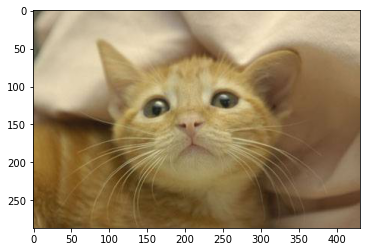

In [8]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open(fname)
plt.imshow(img);

### 이미지 확인2 - OpenCV image
- OpenCV 는 B G R 순서로 이미지를 읽어옴
    - cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    - img2[:, :, ::-1]
    - 위 두가지 중 하나를 쓰면 일반적인 색상으로 볼 수 있게됨.
- OpenCV 데이터는 numpy array임

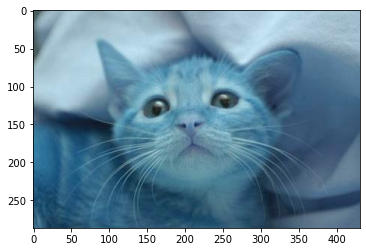

In [9]:
import cv2 
img2 = cv2.imread(fname)
plt.imshow(img2);

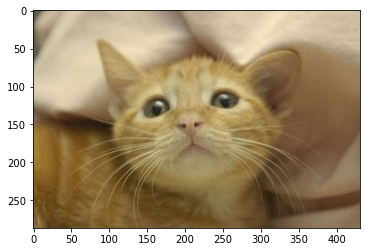

In [10]:
img3 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img3);

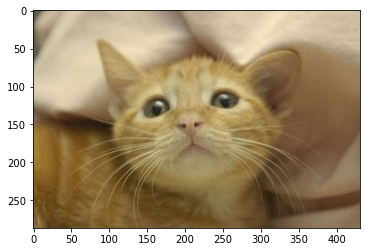

In [11]:
img2 = img2[:, :, ::-1]
plt.imshow(img2);

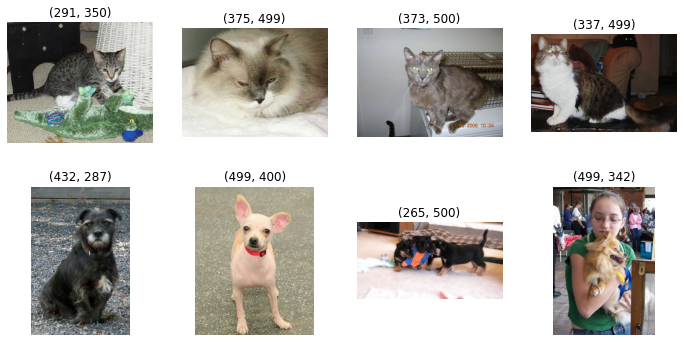

In [12]:
plt.figure(figsize = (12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i + 5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])


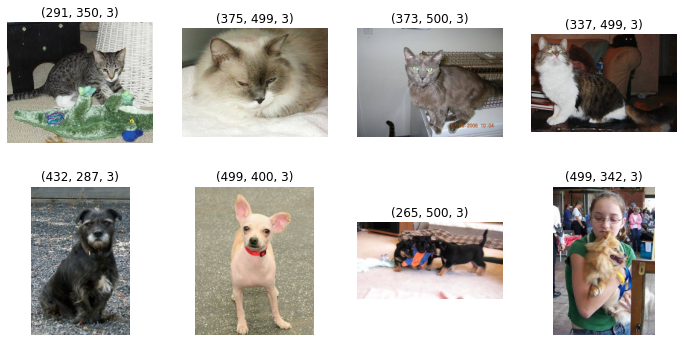

In [13]:
plt.figure(figsize = (12, 6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape)
    plt.subplot(2, 4, i + 5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape)

## 모델 구성 및 설정

In [14]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
model = Sequential([ 
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [23]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [24]:
model_path = 'best-cats-and-dogs-v1.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

### 파일에서 이미지를 읽어서 학습시키는 방법

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1 / 255.) # minmax scaler 효과
test_datagen = ImageDataGenerator(rescale = 1 / 255.)

In [26]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
# steps_for_epoch   : 2000건 중 1600은 train. 그중 80을 step으로
hist = model.fit(train_generater, validation_data = test_generater,
                 epochs = 100, steps_per_epoch =100,
                 validation_steps = 50, callbacks = [mc, es])

Epoch 1/100
 20/100 [=====>........................] - ETA: 22s - loss: 0.7115 - accuracy: 0.5470WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10000 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 0.66302, saving model to best-cats-and-dogs-v1.h5
100/100 [==============================] - 9s 86ms/step - loss: 0.7115 - accuracy: 0.5470 - val_loss: 0.6630 - val_accuracy: 0.6460


In [28]:
best_model = load_model(model_path)

## 테스트 이미지 분류

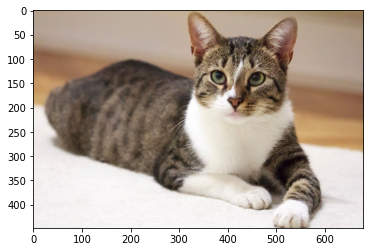

In [30]:
img = cv2.imread('고양이.jpg')[:,:,::-1]
plt.imshow(img);

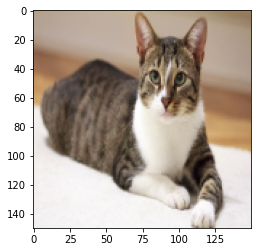

In [31]:
# 150 * 150 size
img = cv2.resize(img, dsize = (150, 150), interpolation = cv2.INTER_AREA)
plt.imshow(img);

In [32]:
# (150, 150, 3)의 3차원을 4차원으로 넣어줘야됨
best_model.predict(img.reshape(1, 150, 150, 3))

array([[1.]], dtype=float32)

In [33]:
%cd /content/

/content


In [34]:
os.listdir('/content')
lst = ['고양이2.jfif',
 '고양이.jpg',
 '개.jpg',
 '고양이1.jpg',
 '개2.jpg']

In [35]:
for fname in lst:
    img = cv2.imread(fname)[:,:,::-1]   # 이미지 읽어오기
    # 큰 그림 줄이기
    if sum(img.shape[:-1]) > 300:
        img = cv2.resize(img, dsize = (150, 150), interpolation = cv2.INTER_AREA)   
    # 작은 그림 늘리기
    else:
        img = cv2.resize(img, dsize = (150, 150), interpolation = cv2.INTER_CUBIC)   

    classes = best_model.predict(img.reshape(1, 150, 150, 3))
    print(f"{fname.split('.')[0]} 은 {classes[0][0]:.4f}로 예측됨.")


고양이2 은 1.0000로 예측됨.
고양이 은 1.0000로 예측됨.
개 은 1.0000로 예측됨.
고양이1 은 1.0000로 예측됨.
개2 은 1.0000로 예측됨.
